## Software empleado

In [1]:
# Bibliotecas
import os, sys
import torch
import importlib
import numpy as np
import polars as pl 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple, Optional, Union

In [2]:
sys.path.append(os.path.abspath("notebooks/"))

# Código propio
from visual_utils import * 

In [3]:
print(pl.__version__)

1.30.0


# PROBLEMA 1
# ESTIMACIÓN DE EDAD

# Carga de los resultados

In [4]:
# Carga de datos
df_AE_raw = pl.read_csv("results/AE_maxillofacial_test_results.csv")

# Primero ordenamos por iteración
df_AE_raw = sort_by_column(df_AE_raw, 'iteration')

# Orden personalizado
custom_order = ['base', 'ICP', 'QR', 'CQR']
# Después ordenamos por tipo de predicción
df_AE_raw = sort_by_column(df_AE_raw, 'pred_model_type', custom_order)

display(df_AE_raw)

pred_model_type,confidence,iteration,pred_point_value,pred_lower_bound,pred_upper_bound,true_value
str,f64,i64,f64,f64,f64,f64
"""base""",0.95,1,24.865715,22.599516,27.131914,25.30411
"""base""",0.95,1,19.595766,17.329567,21.861965,21.67
"""base""",0.95,1,14.848513,12.582314,17.114712,14.890411
"""base""",0.95,1,21.175924,18.909725,23.442123,17.367123
"""base""",0.95,1,22.465553,20.199354,24.731752,23.180822
…,…,…,…,…,…,…
"""CQR""",0.95,5,19.784445,16.801672,22.97352,21.868494
"""CQR""",0.95,5,16.276115,13.750139,19.08052,14.0
"""CQR""",0.95,5,21.670212,18.591805,24.89255,23.4


In [5]:
# Añade nueva columna: interval_size
df_AE_raw = df_AE_raw.with_columns([
    (pl.col('pred_upper_bound')-pl.col('pred_lower_bound')).alias('pred_interval_width')
])

# Añade nueva columna: is_covered
df_AE_raw = df_AE_raw.with_columns([
    ((pl.col("true_value") >= pl.col("pred_lower_bound")) & 
     (pl.col("true_value") <= pl.col("pred_upper_bound")) ).alias("is_covered")
])

display(df_AE_raw)

pred_model_type,confidence,iteration,pred_point_value,pred_lower_bound,pred_upper_bound,true_value,pred_interval_width,is_covered
str,f64,i64,f64,f64,f64,f64,f64,bool
"""base""",0.95,1,24.865715,22.599516,27.131914,25.30411,4.532398,true
"""base""",0.95,1,19.595766,17.329567,21.861965,21.67,4.532398,true
"""base""",0.95,1,14.848513,12.582314,17.114712,14.890411,4.532398,true
"""base""",0.95,1,21.175924,18.909725,23.442123,17.367123,4.532398,false
"""base""",0.95,1,22.465553,20.199354,24.731752,23.180822,4.532398,true
…,…,…,…,…,…,…,…,…
"""CQR""",0.95,5,19.784445,16.801672,22.97352,21.868494,6.171848,true
"""CQR""",0.95,5,16.276115,13.750139,19.08052,14.0,5.330381,true
"""CQR""",0.95,5,21.670212,18.591805,24.89255,23.4,6.300745,true


In [6]:
#
df_AE_by_run = df_AE_raw.group_by(["pred_model_type", "confidence", "iteration"]).agg([
    pl.col("is_covered").mean().alias("empirical_coverage"),
    pl.col("pred_interval_width").mean().alias("mean_interval_width"),
    # pl.col("pred_interval_width").min().alias("min_interval_width"),
    # pl.col("pred_interval_width").quantile(0.25).alias("Q1_interval_width"),
    # pl.col("pred_interval_width").quantile(0.50).alias("Q2_interval_width"),
    # pl.col("pred_interval_width").quantile(0.75).alias("Q3_interval_width"),
    # pl.col("pred_interval_width").max().alias("max_interval_width"),
])

#
color_dict = {"base": "#7f7f7f", "ICP": "#e02b35", "QR": "#59a89c", "CQR" : "#082a54"}

#
df_AE_by_run = df_AE_by_run.with_columns(
    pl.col("pred_model_type").replace(color_dict, default="black").alias("color")
)

display(df_AE_by_run)

/tmp/ipykernel_37342/90711090.py:17: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("pred_model_type").replace(color_dict, default="black").alias("color")


pred_model_type,confidence,iteration,empirical_coverage,mean_interval_width,color
str,f64,i64,f64,f64,str
"""CQR""",0.95,3,0.954461,6.015039,"""#082a54"""
"""base""",0.95,5,0.878717,4.630813,"""#7f7f7f"""
"""ICP""",0.95,6,0.951673,6.415974,"""#e02b35"""
"""base""",0.95,1,0.874071,4.532398,"""#7f7f7f"""
"""QR""",0.95,2,0.892658,4.672614,"""#59a89c"""
…,…,…,…,…,…
"""QR""",0.95,4,0.894981,4.625818,"""#59a89c"""
"""QR""",0.95,5,0.891264,4.593593,"""#59a89c"""
"""ICP""",0.95,1,0.944703,6.17375,"""#e02b35"""


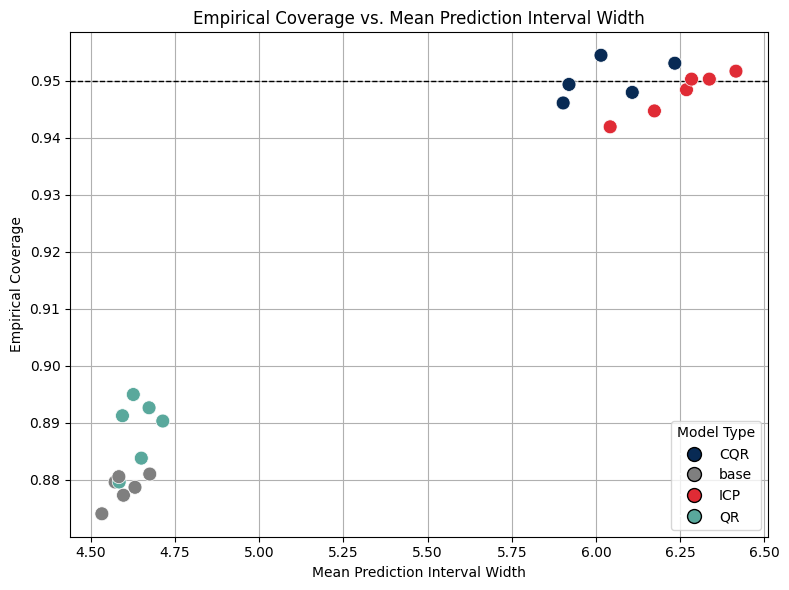

In [7]:
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run['mean_interval_width'],
    empirical_coverages = df_AE_by_run['empirical_coverage'],
    model_types = df_AE_by_run['pred_model_type'],
    colors = df_AE_by_run['color'],
    confidence_level = 0.95
)

In [39]:
# Añadir columna de ranking dentro de cada grupo de {pred_model_type, confidence}
df_AE_by_run = df_AE_by_run.sort(["pred_model_type", "confidence", "mean_interval_width"]) \
    .with_columns([
        pl.col("mean_interval_width")
        .rank("dense")
        .over(["pred_model_type", "confidence"])
        .alias("ranking_mean_interval_width")
    ])
    
display(df_AE_by_run)

pred_model_type,confidence,iteration,empirical_coverage,mean_interval_width,color,ranking_mean_interval_width
str,f64,i64,f64,f64,str,u32
"""CQR""",0.95,4,0.946097,5.902679,"""#082a54""",1
"""CQR""",0.95,5,0.949349,5.92001,"""#082a54""",2
"""CQR""",0.95,3,0.954461,6.015039,"""#082a54""",3
"""CQR""",0.95,2,0.947955,6.107933,"""#082a54""",4
"""CQR""",0.95,1,0.953067,6.234363,"""#082a54""",5
…,…,…,…,…,…,…
"""base""",0.95,2,0.879647,4.571717,"""#7f7f7f""",2
"""base""",0.95,4,0.880576,4.582962,"""#7f7f7f""",3
"""base""",0.95,3,0.877323,4.596496,"""#7f7f7f""",4


In [28]:
df_deciles = (
    df_AE_raw
    .group_by(['pred_model_type', 'confidence', 'iteration'])
    .agg([
        pl.col('pred_interval_width').quantile(0.1).alias('decile_10'),
        pl.col('pred_interval_width').quantile(0.2).alias('decile_20'),
        pl.col('pred_interval_width').quantile(0.3).alias('decile_30'),
        pl.col('pred_interval_width').quantile(0.4).alias('decile_40'),
        pl.col('pred_interval_width').quantile(0.5).alias('decile_50'),
        pl.col('pred_interval_width').quantile(0.6).alias('decile_60'),
        pl.col('pred_interval_width').quantile(0.7).alias('decile_70'),
        pl.col('pred_interval_width').quantile(0.8).alias('decile_80'),
        pl.col('pred_interval_width').quantile(0.9).alias('decile_90'),
    ])
    .sort(['pred_model_type', 'confidence'])
)

display(df_deciles)

pred_model_type,confidence,iteration,decile_10,decile_20,decile_30,decile_40,decile_50,decile_60,decile_70,decile_80,decile_90
str,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CQR""",0.95,2,5.250676,5.494101,5.773489,6.004597,6.248999,6.394672,6.519337,6.631534,6.765255
"""CQR""",0.95,1,5.353707,5.621047,5.876049,6.127034,6.342388,6.52232,6.661789,6.78154,6.924167
"""CQR""",0.95,3,5.142517,5.414012,5.694342,5.940602,6.150904,6.304949,6.431826,6.544413,6.65798
"""CQR""",0.95,4,5.082467,5.309441,5.533923,5.790197,6.014174,6.185598,6.320896,6.423109,6.565818
"""CQR""",0.95,5,5.047754,5.304874,5.578211,5.837419,6.063721,6.22196,6.335971,6.456327,6.580029
…,…,…,…,…,…,…,…,…,…,…,…
"""base""",0.95,5,4.630813,4.630813,4.630813,4.630813,4.630814,4.630814,4.630814,4.630814,4.630814
"""base""",0.95,3,4.596495,4.5964955,4.596496,4.596496,4.596496,4.596496,4.596497,4.596497,4.596497
"""base""",0.95,1,4.532398,4.532398,4.532398,4.532398,4.532398,4.532398,4.532398,4.532399,4.532399


In [25]:
#
result = (
    df_AE_raw
    .with_columns([
        # Crear decil según ancho de intervalo
        pl.col("pred_interval_width")
          .qcut(10)
          .alias("width_decile")
    ])
    .group_by(["pred_model_type", "confidence", "width_decile"], maintain_order=True)
    .agg([
        # Contar instancias no cubiertas por decil
        pl.sum((~pl.col("is_covered")).cast(pl.UInt32)).alias("n_not_covered"),
        pl.count().alias("total")
    ])
    .sort(["pred_model_type", "confidence", "width_decile"])
)

display(result)

TypeError: invalid input for `col`

Expected `str` or `DataType`, got 'Expr'.

In [17]:
# Añade columna con decil (del 0 al 9) por grupo (pred_model_type, confidence)
df_AE_by_pred_model_type = df_AE_raw.with_columns([
    pl.col("pred_interval_width")
    .rank("ordinal", descending=False)
    .over(["pred_model_type", "confidence"])
    .alias("interval_rank")
])

# Número total de filas por grupo
df_AE_by_pred_model_type = df_AE_by_pred_model_type.with_columns([
    pl.len().over(["pred_model_type", "confidence"]).alias("group_count")
])

# Calcula el decil como entero de 0 a 9
df_AE_by_pred_model_type = df_AE_by_pred_model_type.with_columns([
    ((pl.col("interval_rank") * 10) / pl.col("group_count"))
    .floor()
    .cast(pl.Int8)
    .clip(0,9)  # Asegura que los valores estén entre 0 y 9
    .alias("interval_width_decil")
])

display(df_AE_by_pred_model_type)

pred_model_type,confidence,iteration,pred_point_value,pred_lower_bound,pred_upper_bound,true_value,pred_interval_width,is_covered,interval_rank,group_count,interval_width_decil
str,f64,i64,f64,f64,f64,f64,f64,bool,u32,u32,i8
"""base""",0.95,1,24.865715,22.599516,27.131914,25.30411,4.532398,true,90,12912,0
"""base""",0.95,1,19.595766,17.329567,21.861965,21.67,4.532398,true,454,12912,0
"""base""",0.95,1,14.848513,12.582314,17.114712,14.890411,4.532398,true,455,12912,0
"""base""",0.95,1,21.175924,18.909725,23.442123,17.367123,4.532398,false,91,12912,0
"""base""",0.95,1,22.465553,20.199354,24.731752,23.180822,4.532398,true,456,12912,0
…,…,…,…,…,…,…,…,…,…,…,…
"""CQR""",0.95,5,19.784445,16.801672,22.97352,21.868494,6.171848,true,5486,10760,5
"""CQR""",0.95,5,16.276115,13.750139,19.08052,14.0,5.330381,true,1750,10760,1
"""CQR""",0.95,5,21.670212,18.591805,24.89255,23.4,6.300745,true,6360,10760,5


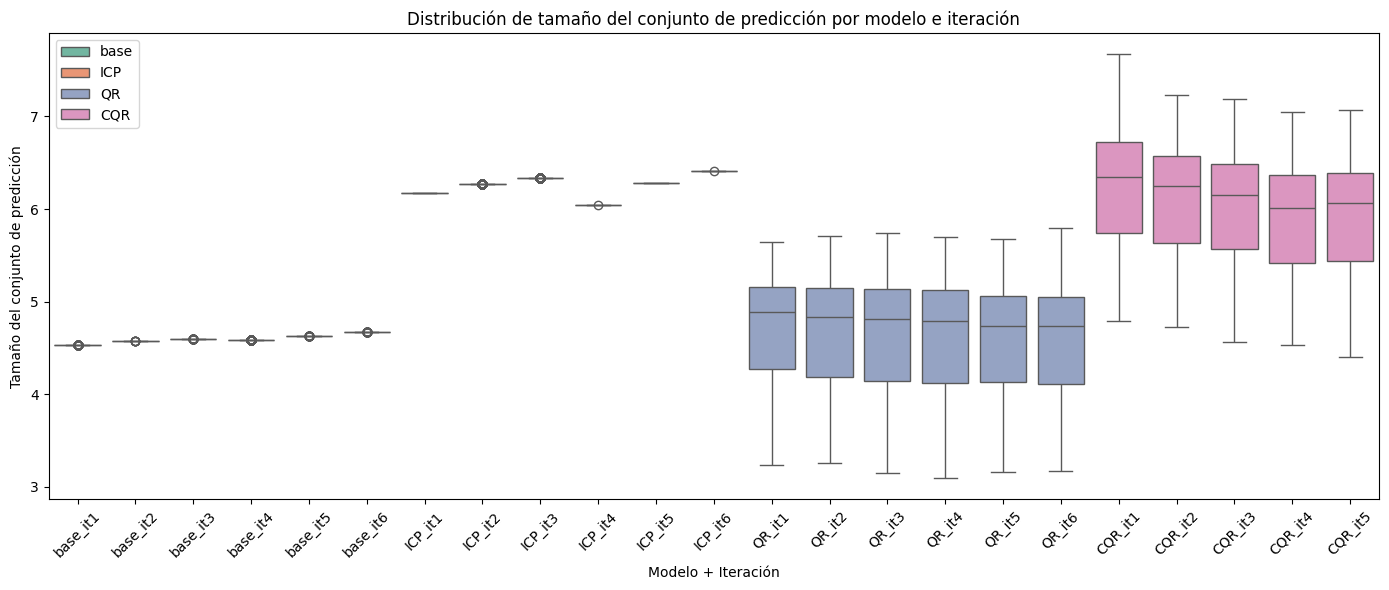

In [8]:
# Filtra (opcional): por ejemplo, solo confidence = 0.95
df_plot = df_AE_raw.filter(pl.col("confidence") == 0.95)

# Extrae columnas necesarias como listas de Python
model_types = df_plot["pred_model_type"].to_list()
iterations = df_plot["iteration"].to_list()
widths = df_plot["pred_interval_width"].to_list()

# Creamos las etiquetas agrupadas como "modelo_iteración"
group_labels = [f"{m}_it{it}" for m, it in zip(model_types, iterations)]

# Preparar DataFrame como diccionario (para seaborn)
plot_data = {
    "group": group_labels,
    "pred_model_type": model_types,
    "iteration": iterations,
    "pred_interval_width": widths,
}

# Gráfico
plt.figure(figsize=(14, 6))
sns.boxplot(
    x=plot_data["group"],
    y=plot_data["pred_interval_width"],
    hue=plot_data["pred_model_type"],  # o "iteration", según cómo prefieras agrupar
    palette="Set2"
)
plt.title("Distribución de tamaño del conjunto de predicción por modelo e iteración")
plt.xlabel("Modelo + Iteración")
plt.ylabel("Tamaño del conjunto de predicción")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
def plot_density_interval_widths(df: pl.DataFrame) -> None:
    
    df.write_csv("temp.csv")

    df_pandas = pd.read_csv("temp.csv")
    # Borrar el archivo CSV
    os.remove("temp.csv")

    plt.figure(figsize=(10, 6))
    sns.violinplot(
        x='pred_model_type',
        y='pred_interval_width',
        hue='is_covered',
        data=df_pandas,
        split=True,
        inner="quart"
    )
    plt.title('Distribución del Interval Width por Tipo de Modelo')
    plt.xlabel('Tipo de Modelo')
    plt.ylabel('Interval Width')
    plt.legend(title='Sex Embedding')
    plt.tight_layout()
    plt.show()

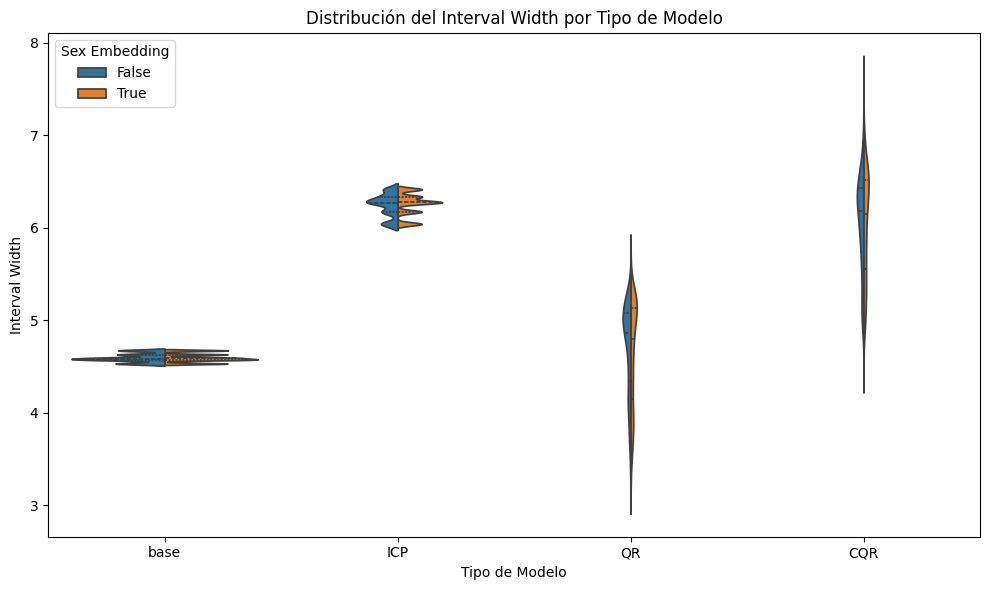

In [30]:
plot_density_interval_widths(df_AE_raw)

# PROBLEMA 2 
# ESTIMACIÓN DE MAYORÍA DE EDAD

## Carga de resultados

In [120]:
#
df_AMM_raw = pl.read_csv("results/AMM_maxillofacial_test_results.csv")

# Primero ordenamos por iteración
df_AMM_raw = sort_by_column(df_AMM_raw, 'iteration')

# Orden personalizado
custom_order = ['base', 'LAC', 'MCM']
# Después ordenamos por tipo de predicción
df_AMM_raw = sort_by_column(df_AMM_raw, 'pred_model_type', custom_order)

display(df_AMM_raw)

pred_model_type,confidence,iteration,pred_class,pred_set_under_18,pred_set_over_18,true_class
str,f64,i64,i64,i64,i64,i64
"""base""",0.95,1,1,0,1,1
"""base""",0.95,1,1,0,1,1
"""base""",0.95,1,0,1,0,0
"""base""",0.95,1,1,0,1,0
"""base""",0.95,1,1,0,1,1
…,…,…,…,…,…,…
"""MCM""",0.95,4,1,1,1,1
"""MCM""",0.95,4,0,1,0,0
"""MCM""",0.95,4,1,0,1,1


In [121]:
# Añade nueva columna: pred_set_size
df_AMM_raw = df_AMM_raw.with_columns([
    (pl.col('pred_set_under_18')+pl.col('pred_set_over_18')).alias('pred_set_size')
])

# Añade nueva columna: is_covered
df_AMM_raw = df_AMM_raw.with_columns([
    (
        ((pl.col("true_class") == 0) & (pl.col("pred_set_under_18") == 1)) |
        ((pl.col("true_class") == 1) & (pl.col("pred_set_over_18") == 1))
    ).alias("is_covered")
])

display(df_AMM_raw)

pred_model_type,confidence,iteration,pred_class,pred_set_under_18,pred_set_over_18,true_class,pred_set_size,is_covered
str,f64,i64,i64,i64,i64,i64,i64,bool
"""base""",0.95,1,1,0,1,1,1,true
"""base""",0.95,1,1,0,1,1,1,true
"""base""",0.95,1,0,1,0,0,1,true
"""base""",0.95,1,1,0,1,0,1,false
"""base""",0.95,1,1,0,1,1,1,true
…,…,…,…,…,…,…,…,…
"""MCM""",0.95,4,1,1,1,1,2,true
"""MCM""",0.95,4,0,1,0,0,1,true
"""MCM""",0.95,4,1,0,1,1,1,true


In [123]:
#
summary_AMM_df = df_AMM_raw.group_by(["pred_model_type", "confidence", "iteration"]).agg([
    pl.col("is_covered").mean().alias("empirical_coverage"),
    pl.col("pred_set_size").mean().alias("mean_set_size"),
    pl.col("pred_set_size").min().alias("min_set_size"),
    pl.col("pred_set_size").quantile(0.25).alias("Q1_set_size"),
    pl.col("pred_set_size").quantile(0.50).alias("Q2_set_size"),
    pl.col("pred_set_size").quantile(0.75).alias("Q3_set_size"),
    pl.col("pred_set_size").max().alias("max_set_size"),
])

#
color_dict = {"base": "#7f7f7f", "LAC": "#e02b35", "MCM": "#59a89c"}

#
summary_AMM_df = summary_AMM_df.with_columns(
    pl.col("pred_model_type").replace(color_dict, default="black").alias("color")
)

display(summary_AMM_df)

/tmp/ipykernel_6322/2954158576.py:17: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("pred_model_type").replace(color_dict, default="black").alias("color")


pred_model_type,confidence,iteration,empirical_coverage,mean_set_size,min_set_size,Q1_set_size,Q2_set_size,Q3_set_size,max_set_size,color
str,f64,i64,f64,f64,i64,f64,f64,f64,i64,str
"""LAC""",0.95,4,0.939591,1.190985,1,1.0,1.0,1.0,2,"""#e02b35"""
"""LAC""",0.95,3,0.951208,1.227695,1,1.0,1.0,1.0,2,"""#e02b35"""
"""MCM""",0.95,2,0.943773,1.207714,1,1.0,1.0,1.0,2,"""#59a89c"""
"""base""",0.95,3,0.875929,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""
"""MCM""",0.95,4,0.944238,1.210037,1,1.0,1.0,1.0,2,"""#59a89c"""
…,…,…,…,…,…,…,…,…,…,…
"""base""",0.95,1,0.878717,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""
"""MCM""",0.95,1,0.939126,1.188197,1,1.0,1.0,1.0,2,"""#59a89c"""
"""base""",0.95,2,0.878717,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""


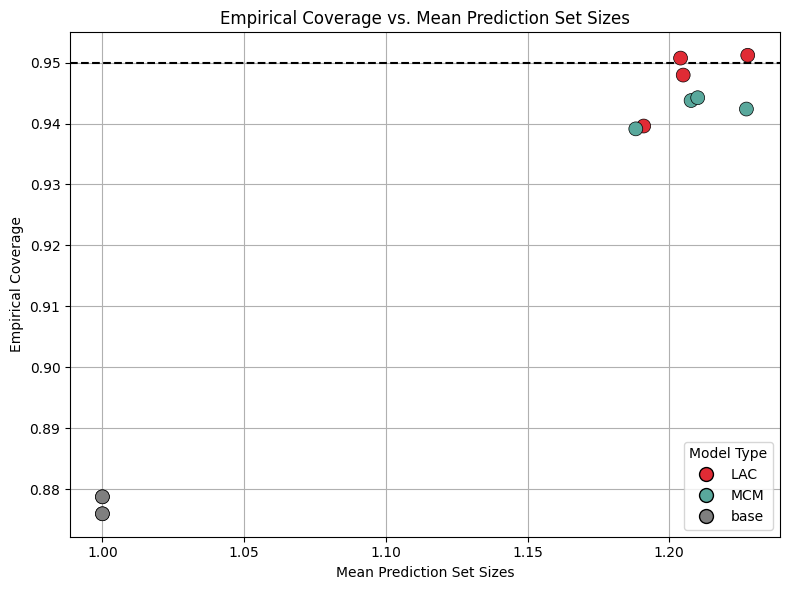

In [124]:
plot_coverage_vs_set_size(
    mean_set_sizes = summary_AMM_df['mean_set_size'],
    empirical_coverages = summary_AMM_df['empirical_coverage'],
    model_types = summary_AMM_df['pred_model_type'],
    colors = summary_AMM_df['color'],
    confidence_level = 0.95
)

In [ ]:
# def plot_stacked_pred_set_distribution(df: pl.DataFrame):

#     # Paso 1: Crear columna categórica pred_set_type usando pl.when-then encadenado con pl.coalesce
#     pred_set_type_expr = pl.coalesce(
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 0)).then(pl.lit("only_0")),
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 1)).then(pl.lit("both")),
#         pl.when((pl.col('pred_set_under_18') == 0) & (pl.col('pred_set_over_18') == 1)).then(pl.lit("only_1")),
#         pl.lit("none")
#     ).alias("pred_set_type")

#     # Paso 2: Agrupar
#     grouped = df.group_by(
#         ["pred_model_type", "confidence", "iteration", "pred_set_type"]
#     ).agg([
#         pl.count().alias("count")
#     ])

#     # Paso 3: Pivotear
#     pivoted = grouped.pivot(
#         values="count",
#         index=["pred_model_type", "iteration"],
#         columns="pred_set_type",
#         aggregate_function="first"
#     ).fill_null(0)

#     # Paso 4: Convertir y asegurar columnas
#     df_plot = pivoted.to_pandas()
#     df_plot["x_label"] = df_plot["pred_model_type"] + "_iter_" + df_plot["iteration"].astype(str)

#     for col in ["only_0", "both", "only_1"]:
#         if col not in df_plot.columns:
#             df_plot[col] = 0

#     # Paso 5: Plot
#     x = np.arange(len(df_plot["x_label"]))
#     only_0 = df_plot["only_0"]
#     both = df_plot["both"]
#     only_1 = df_plot["only_1"]

#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.bar(x, only_0, label="{0}", color="#9ecae1")
#     ax.bar(x, both, bottom=only_0, label="{0,1}", color="#6baed6")
#     ax.bar(x, only_1, bottom=only_0 + both, label="{1}", color="#2171b5")

#     ax.set_xticks(x)
#     ax.set_xticklabels(df_plot["x_label"], rotation=45, ha="right")
#     ax.set_ylabel("Número de instancias")
#     ax.set_title("Distribución de conjuntos de predicción por modelo e iteración")
#     ax.legend(title="Pred set")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# plot_stacked_pred_set_distribution(df_AMM_raw)

/tmp/ipykernel_6322/138796192.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")


ColumnNotFoundError: pred_set_type

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["pred_model_type", "confidence", "iteration", "pred_class", ...]; PROJECT */9 COLUMNS

# PROBLEMA 3
# ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## Carga de datos

In [107]:
#
df_AMSC_raw = pl.read_csv("results/AMSC_maxillofacial_test_results.csv")

# Primero ordenamos por iteración
df_AMSC_raw = sort_by_column(df_AMSC_raw, 'iteration')

# Orden personalizado
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS']
# Después ordenamos por tipo de predicción
df_AMSC_raw = sort_by_column(df_AMSC_raw, 'pred_model_type', custom_order)

display(df_AMSC_raw)

pred_model_type,confidence,iteration,pred_class,pred_set_male_under_18,pred_set_male_over_18,pred_set_female_under_18,pred_set_female_over_18,true_class
str,f64,i64,i64,i64,i64,i64,i64,i64
"""base""",0.95,1,3,0,0,0,1,3
"""base""",0.95,1,1,0,1,0,0,1
"""base""",0.95,1,2,0,0,1,0,2
"""base""",0.95,1,3,0,0,0,1,2
"""base""",0.95,1,1,0,1,0,0,1
…,…,…,…,…,…,…,…,…
"""RAPS""",0.95,4,3,0,1,1,1,3
"""RAPS""",0.95,4,2,1,0,1,1,2
"""RAPS""",0.95,4,3,0,1,1,1,1


In [108]:
# Añade nueva columna: pred_set_size
df_AMSC_raw = df_AMSC_raw.with_columns([
    (pl.col('pred_set_male_under_18')+pl.col('pred_set_male_over_18')+
     pl.col('pred_set_female_under_18')+pl.col('pred_set_female_over_18')).alias('pred_set_size')
])

# Añade nueva columna: is_covered
df_AMSC_raw = df_AMSC_raw.with_columns([
    (
        ((pl.col("true_class") == 0) & (pl.col("pred_set_male_under_18") == 1)) |
        ((pl.col("true_class") == 1) & (pl.col("pred_set_male_over_18") == 1)) |
        ((pl.col("true_class") == 2) & (pl.col("pred_set_female_under_18") == 1)) |
        ((pl.col("true_class") == 3) & (pl.col("pred_set_female_over_18") == 1))
    ).alias("is_covered")
])

display(df_AMSC_raw)

pred_model_type,confidence,iteration,pred_class,pred_set_male_under_18,pred_set_male_over_18,pred_set_female_under_18,pred_set_female_over_18,true_class,pred_set_size,is_covered
str,f64,i64,i64,i64,i64,i64,i64,i64,i64,bool
"""base""",0.95,1,3,0,0,0,1,3,1,true
"""base""",0.95,1,1,0,1,0,0,1,1,true
"""base""",0.95,1,2,0,0,1,0,2,1,true
"""base""",0.95,1,3,0,0,0,1,2,1,false
"""base""",0.95,1,1,0,1,0,0,1,1,true
…,…,…,…,…,…,…,…,…,…,…
"""RAPS""",0.95,4,3,0,1,1,1,3,3,true
"""RAPS""",0.95,4,2,1,0,1,1,2,3,true
"""RAPS""",0.95,4,3,0,1,1,1,1,3,true


In [ ]:
#
summary_AMSC_df = df_AMSC_raw.group_by(["pred_model_type", "confidence", "iteration"]).agg([
    pl.col("is_covered").mean().alias("empirical_coverage"),
    pl.col("pred_set_size").mean().alias("mean_interval_size"),
    pl.col("pred_set_size").min().alias("min_interval_size"),
    pl.col("pred_set_size").quantile(0.25).alias("Q1_interval_size"),
    pl.col("pred_set_size").quantile(0.50).alias("Q2_interval_size"),
    pl.col("pred_set_size").quantile(0.75).alias("Q3_interval_size"),
    pl.col("pred_set_size").max().alias("max_interval_size"),
])

#
color_dict = {
    "base": "#7f7f7f", "LAC" : "#e02b35", "MCM": "#59a89c", "APS" : "#082a54", "RAPS": "#a559aa"
}

#
summary_AMSC_df = summary_AMSC_df.with_columns(
    pl.col("pred_model_type").replace(color_dict, default="black").alias("color")
)

display(summary_AMSC_df)

/tmp/ipykernel_6322/847231806.py:20: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("pred_model_type").replace(color_dict, default="black").alias("color")


pred_model_type,confidence,iteration,empirical_coverage,mean_interval_size,min_interval_size,Q1_interval_size,Q2_interval_size,Q3_interval_size,max_interval_size,color
str,f64,i64,f64,f64,i64,f64,f64,f64,i64,str
"""base""",0.95,4,0.752323,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""
"""MCM""",0.95,3,0.934015,1.89684,1,1.0,2.0,2.0,4,"""#59a89c"""
"""MCM""",0.95,1,0.952602,1.900558,1,1.0,2.0,2.0,4,"""#59a89c"""
"""base""",0.95,3,0.763476,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""
"""base""",0.95,1,0.777881,1.0,1,1.0,1.0,1.0,1,"""#7f7f7f"""
…,…,…,…,…,…,…,…,…,…,…
"""MCM""",0.95,4,0.947955,1.898234,1,1.0,2.0,2.0,4,"""#59a89c"""
"""RAPS""",0.95,3,0.966078,2.517658,1,2.0,3.0,3.0,3,"""#a559aa"""
"""APS""",0.95,4,0.947026,2.341543,1,2.0,2.0,3.0,3,"""#082a54"""


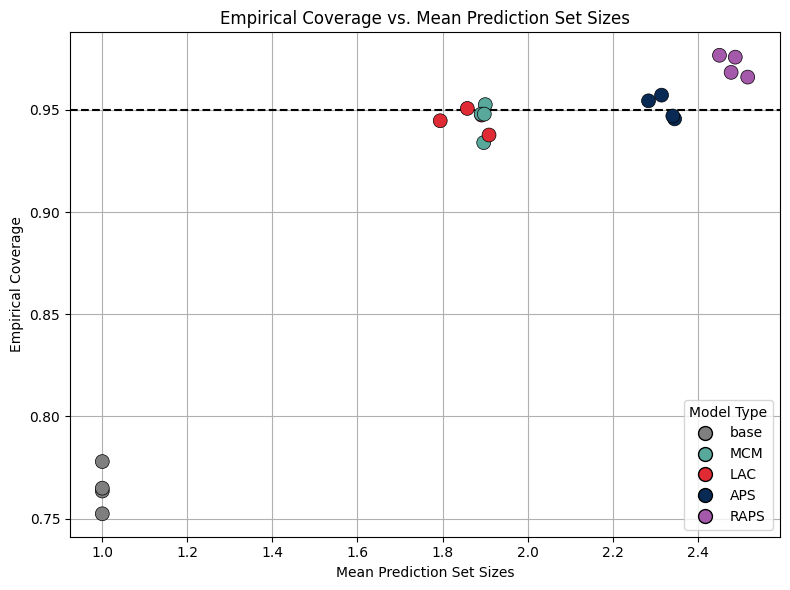

In [110]:
plot_coverage_vs_set_size(
    mean_set_sizes = summary_AMSC_df['mean_interval_size'],
    empirical_coverages = summary_AMSC_df['empirical_coverage'],
    model_types = summary_AMSC_df['pred_model_type'],
    colors = summary_AMSC_df['color'],
    confidence_level = 0.95
)